новые вычисления модели KAN
попытка балансировки данных

In [35]:
import torch
from kan import KAN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [36]:
df = pd.read_csv("/home/nail/Documents/Natalia/IoT/Datas/CIC_IOT_Dataset2023/IoT_Intrusion/IoT_Intrusion.csv")

In [37]:
df = df.dropna()

In [38]:
X = df[df.columns[0:-1]].fillna(0).reset_index(drop=True)
y = df['label']== 'BenignTraffic'

In [40]:
from imblearn.over_sampling import SMOTE
import torch

# Преобразуем метки 'label' в бинарный формат (0 и 1)
X = df[df.columns[0:-1]].fillna(0).reset_index(drop=True)
y = (df['label'] == 'BenignTraffic').astype(int)

# Разделение данных на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5)

# Применение SMOTE только к обучающим данным для увеличения количества примеров меньшинства
smote = SMOTE(random_state=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Преобразование данных в тензоры для PyTorch
train_input = torch.tensor(X_train_resampled.values, dtype=torch.float32).to(device)  # Преобразуем в numpy-массив
train_label = torch.tensor(y_train_resampled.values, dtype=torch.long).to(device)  # Преобразуем в numpy-массив

val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32).to(device)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.long).to(device)

test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.long).to(device)

# Проверка размеров полученных выборок
print(f"Train size (after SMOTE): {len(X_train_resampled)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size (after SMOTE): 1433684
Validation size: 157286
Test size: 157287


In [41]:
print(f"Train input size: {train_input.size()}")
print(f"Train label size: {train_label.size()}")


Train input size: torch.Size([1433684, 46])
Train label size: torch.Size([1433684])


In [42]:
# Проверка баланса классов в обучающей, валидационной и тестовой выборках
print("Class distribution in training set:")
print(y_train.value_counts())

print("\nClass distribution in validation set:")
print(y_val.value_counts())

print("\nClass distribution in test set:")
print(y_test.value_counts())

Class distribution in training set:
label
0    716842
1     17160
Name: count, dtype: int64

Class distribution in validation set:
label
0    153578
1      3708
Name: count, dtype: int64

Class distribution in test set:
label
0    153679
1      3608
Name: count, dtype: int64


In [43]:
# Проверка баланса классов с PyTorch
train_class_counts = torch.bincount(train_label)
val_class_counts = torch.bincount(val_label)
test_class_counts = torch.bincount(test_label)

print(f"Class distribution in training set: {train_class_counts}")
print(f"Class distribution in validation set: {val_class_counts}")
print(f"Class distribution in test set: {test_class_counts}")

Class distribution in training set: tensor([716842, 716842])
Class distribution in validation set: tensor([153578,   3708])
Class distribution in test set: tensor([153679,   3608])


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
import time
from sklearn.feature_selection import VarianceThreshold

# Удаляем признаки с нулевой дисперсией (константные признаки)
constant_filter = VarianceThreshold(threshold=0)  # Порог 0 удаляет только константные признаки
X_train_filtered = constant_filter.fit_transform(X_train)
X_val_filtered = constant_filter.transform(X_val)
X_test_filtered = constant_filter.transform(X_test)

# Отбор признаков
N = 10  # Количество отбираемых признаков
selector = SelectKBest(f_classif, k=N)
X_train_selected = selector.fit_transform(X_train_filtered, y_train)
X_val_selected = selector.transform(X_val_filtered)
X_test_selected = selector.transform(X_test_filtered)

# Обучение модели с взвешиванием классов
model = RandomForestClassifier(class_weight='balanced')

# Замер времени обучения
start_train_time = time.perf_counter()
model.fit(X_train_selected, y_train)  # Обучение модели
end_train_time = time.perf_counter()

# Прогнозирование на валидационных данных
start_predict_time = time.perf_counter()
y_pred_logreg = model.predict(X_val_selected)
end_predict_time = time.perf_counter()

# Оценка точности
accuracy = accuracy_score(y_val, y_pred_logreg)
print(f"Accuracy with top {N} features: {accuracy:.4f}")

# Проверка размеров предсказанных и истинных меток
print(f"Dimensions y_val: {y_val.shape}, y_pred_logreg: {y_pred_logreg.shape}")

# Вывод времени выполнения
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")


Accuracy with top 10 features: 0.9912
Dimensions y_val: (157286,), y_pred_logreg: (157286,)
Training time: 51.1683 seconds
Prediction time: 0.7164 seconds


In [49]:
import torch
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
import time

# Проверка доступности устройства (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Удаление постоянных признаков (константных признаков)
constant_filter = VarianceThreshold(threshold=0)  # Удаляет все признаки с нулевой дисперсией
X_train_var = constant_filter.fit_transform(X_train)
X_val_var = constant_filter.transform(X_val)
X_test_var = constant_filter.transform(X_test)

# Шаг отбора признаков (SelectKBest)
N = 10  # Количество отбираемых признаков
selector = SelectKBest(f_classif, k=N)
X_train_selected = selector.fit_transform(X_train_var, y_train)
X_val_selected = selector.transform(X_val_var)
X_test_selected = selector.transform(X_test_var)

# Получение индексов отобранных признаков
top_n_indices = selector.get_support(indices=True)
print(f"Selected feature indices: {top_n_indices}")

# Инициализация модели
model = KAN(width=[10, [5, 3], 2], grid=5, k=2)  # Убедитесь, что модель корректно определена
model.to(device)

# Преобразуем отобранные данные в тензоры и переносим их на нужное устройство
train_input = torch.tensor(X_train_selected, dtype=torch.float32).to(device)
val_input = torch.tensor(X_val_selected, dtype=torch.float32).to(device)
test_input = torch.tensor(X_test_selected, dtype=torch.float32).to(device)

# Переносим метки на нужное устройство
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.long).to(device)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.long).to(device)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.long).to(device)

# Проверка размеров данных
print(f"Train input shape: {train_input.shape}")
print(f"Val input shape: {val_input.shape}")
print(f"Test input shape: {test_input.shape}")


Selected feature indices: [ 3 11 16 18 30 31 32 33 37 39]
checkpoint directory created: ./model
saving model version 0.0
Train input shape: torch.Size([734002, 10])
Val input shape: torch.Size([157286, 10])
Test input shape: torch.Size([157287, 10])


In [50]:
import torch
import torch.optim as optim
from sklearn.metrics import classification_report

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция потерь
criterion = torch.nn.CrossEntropyLoss()

# Функция для вычисления точности на обучающем наборе
def train_acc(train_input, train_label):
    model.eval()  # Убедимся, что модель в режиме оценки (без обновления градиентов)
    with torch.no_grad():
        preds = torch.argmax(model(train_input), dim=1)
        accuracy = torch.mean((preds == train_label).float())
    print(f"Train Accuracy: {accuracy.item():.4f}")
    return accuracy

# Функция для вычисления точности на тестовом наборе
def test_acc(test_input, test_label):
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(test_input), dim=1)
        print(classification_report(test_label.cpu(), preds.cpu()))  # Переводим в CPU для правильного вывода
        accuracy = torch.mean((preds == test_label).float())
    print(f"Test Accuracy: {accuracy.item():.4f}")
    return accuracy

# Пример использования:
# После тренировки модели вычисляем точность на обучающих и тестовых данных
train_accuracy = train_acc(train_input, train_label)
test_accuracy = test_acc(test_input, test_label)


Train Accuracy: 0.5118
              precision    recall  f1-score   support

           0       0.98      0.51      0.67    153679
           1       0.03      0.63      0.06      3608

    accuracy                           0.51    157287
   macro avg       0.51      0.57      0.36    157287
weighted avg       0.96      0.51      0.66    157287

Test Accuracy: 0.5126


In [52]:
# Функция для вычисления точности
def train_acc(train_input, train_label):
    model.eval()  # Убедимся, что модель в режиме оценки (без обновления градиентов)
    with torch.no_grad():
        preds = torch.argmax(model(train_input), dim=1)
        accuracy = torch.mean((preds == train_label).float())
    print(f"Train Accuracy: {accuracy.item():.4f}")
    return accuracy

def test_acc(test_input, test_label):
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(test_input), dim=1)
        print(classification_report(test_label, preds))
        accuracy = torch.mean((preds == test_label).float())
    print(f"Test Accuracy: {accuracy.item():.4f}")
    return accuracy

# Замер времени обучения
start_train_time = time.perf_counter()

# Обучение модели
model.train()  # Убедитесь, что модель в режиме тренировки
for step in range(100):  # Количество шагов (итераций)
    try:
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прогон через модель
        outputs = model(train_input)
        
        # Вычисляем функцию потерь
        loss = criterion(outputs, train_label)
        
        # Вычисляем градиенты
        loss.backward()
        
        # Шаг оптимизатора
        optimizer.step()
        
        # Печать каждые 10 шагов
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")
    except Exception as e:
        print(f"Error at step {step}: {str(e)}")
        break

end_train_time = time.perf_counter()

# Замер времени выполнения предсказаний
start_predict_time = time.perf_counter()

model.eval()  # Переводим модель в режим оценки
with torch.no_grad():
    val_pred = model(val_input)
    val_pred_labels = torch.argmax(val_pred, dim=1)

end_predict_time = time.perf_counter()

# После тренировки модели вычисляем точность
train_accuracy = train_acc(train_input, train_label)  # Передаем нужные данные
val_accuracy = test_acc(test_input, test_label)  # Передаем нужные данные

# Вывод результатов
print(f"Train Accuracy: {train_accuracy.item():.4f}")
print(f"Validation Accuracy: {val_accuracy.item():.4f}")

# Вывод времени обучения и времени предсказания
train_time = end_train_time - start_train_time
predict_time = end_predict_time - start_predict_time
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")

# Освобождаем память
torch.cuda.empty_cache()


Step 0, Loss: 26.6916
Step 10, Loss: 23.9136
Step 20, Loss: 21.6141
Step 30, Loss: 19.7544
Step 40, Loss: 18.1967
Step 50, Loss: 16.8796
Step 60, Loss: 15.6967
Step 70, Loss: 14.6144
Step 80, Loss: 13.6326
Step 90, Loss: 12.7427
Train Accuracy: 0.9822
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    153679
           1       0.61      0.56      0.58      3608

    accuracy                           0.98    157287
   macro avg       0.80      0.77      0.79    157287
weighted avg       0.98      0.98      0.98    157287

Test Accuracy: 0.9815
Train Accuracy: 0.9822
Validation Accuracy: 0.9815
Training Time: 792.3290 seconds
Prediction Time: 0.7556 seconds


F1-score: 0.5807
AUC-ROC: 0.7598
Precision for each class: [0.9896403  0.60541353]


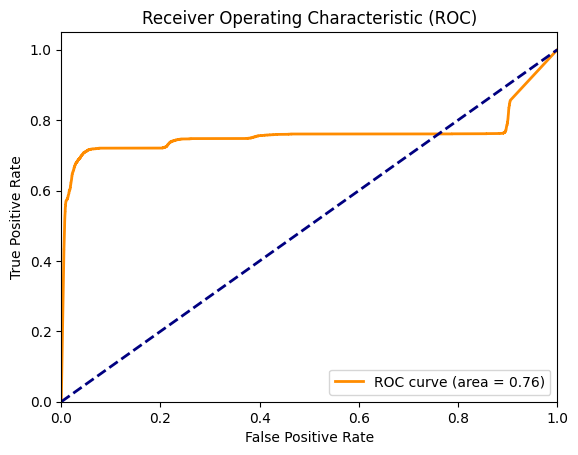

F1-score: 0.5989
AUC-ROC: 0.7750
Precision for each class: [0.98975785 0.62485346]


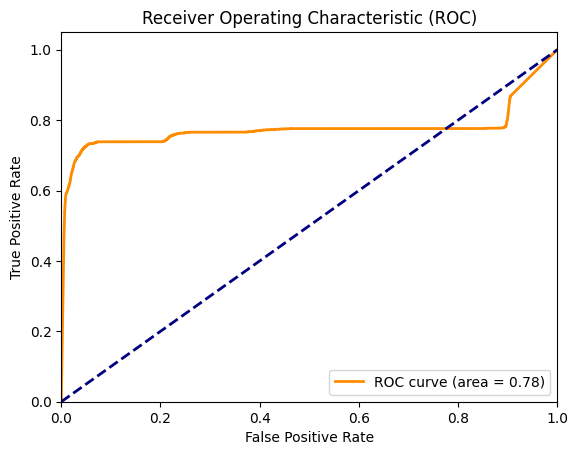

Prediction Time: 1.6601 seconds


In [54]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_score
import matplotlib.pyplot as plt

# Функция для вычисления F1-score, AUC-ROC и точности
def evaluate_model(preds, true_labels, preds_prob):
    # Расчёт F1-score
    f1 = f1_score(true_labels.cpu(), preds.cpu())
    print(f"F1-score: {f1:.4f}")
    
    # Расчёт AUC-ROC
    auc_roc = roc_auc_score(true_labels.cpu(), preds_prob.cpu())
    print(f"AUC-ROC: {auc_roc:.4f}")
    
    # Расчёт точности для каждого класса
    precision = precision_score(true_labels.cpu(), preds.cpu(), average=None)
    print(f"Precision for each class: {precision}")
    
    # Построение графика ROC-кривой
    fpr, tpr, thresholds = roc_curve(true_labels.cpu(), preds_prob.cpu())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Вычисление вероятностей для AUC-ROC
def get_pred_prob(model, input_data):
    model.eval()
    with torch.no_grad():
        preds_prob = torch.softmax(model(input_data), dim=1)[:, 1]  # Вероятности для положительного класса
    return preds_prob

# После тренировки модели вычисляем метрики для тестовых данных
model.eval()
with torch.no_grad():
    # Прогнозирование классов и вероятностей
    test_preds = torch.argmax(model(test_input), dim=1)
    test_pred_prob = get_pred_prob(model, test_input)

    # Оценка точности
    evaluate_model(test_preds, test_label, test_pred_prob)

# Замер времени выполнения предсказаний
start_predict_time = time.perf_counter()

# Прогнозирование для валидационных данных
model.eval()
with torch.no_grad():
    val_preds = torch.argmax(model(val_input), dim=1)
    val_pred_prob = get_pred_prob(model, val_input)

end_predict_time = time.perf_counter()

# Оценка метрик для валидационных данных
evaluate_model(val_preds, val_label, val_pred_prob)

# Время предсказания
predict_time = end_predict_time - start_predict_time
print(f"Prediction Time: {predict_time:.4f} seconds")


Идентификация ошибок

In [56]:
# Получаем предсказания модели для валидационного набора
with torch.no_grad():
    val_pred = model(val_input)

# Применяем argmax для получения индекса класса с максимальной вероятностью
val_pred = torch.argmax(val_pred, dim=1)

# Получаем индексы, где предсказания не совпадают с истинными метками
incorrect_indices = (val_pred != val_label).nonzero().squeeze()

# Получаем ошибочно классифицированные примеры
incorrect_predictions = val_pred[incorrect_indices]
incorrect_labels = val_label[incorrect_indices]

print(f"Number of incorrect predictions: {len(incorrect_indices)}")


Number of incorrect predictions: 2856


Вывести ошибочные примеры

In [57]:
# Получаем данные для ошибочных примеров
incorrect_data = val_input[incorrect_indices]
incorrect_labels = val_label[incorrect_indices]
incorrect_predictions = val_pred[incorrect_indices]

# Преобразуем ошибочные данные в numpy, чтобы удобно выводить
incorrect_data_np = incorrect_data.cpu().numpy()

# Пример: выводим первые несколько ошибочных примеров
for i in range(5):  # Поменяйте число на нужное количество примеров
    print(f"Example {i}:")
    print(f"  True label: {incorrect_labels[i]}")
    print(f"  Predicted label: {incorrect_predictions[i]}")
    print(f"  Features: {incorrect_data_np[i]}")
    print("------")


Example 0:
  True label: 0
  Predicted label: 1
  Features: [  2.         0.         0.         0.       509.9      478.6538
  27.562098 484.7       38.97869    0.9     ]
------
Example 1:
  True label: 1
  Predicted label: 0
  Features: [101.         1.        97.1        1.       208.8      131.55135
  58.526173 134.8       82.7685     0.9     ]
------
Example 2:
  True label: 0
  Predicted label: 1
  Features: [5.7599998e+01 1.0000000e+00 2.9235000e+03 1.0000000e+00 2.9620000e+03
 1.9265570e+03 6.9348047e+02 1.6588000e+03 9.7023456e+02 1.0000000e+00]
------
Example 3:
  True label: 1
  Predicted label: 0
  Features: [1.0890000e+02 1.0000000e+00 4.0189999e+02 1.0000000e+00 1.1580000e+03
 1.6441545e+02 2.5510147e+02 3.2200000e+02 3.6233081e+02 1.0000000e+00]
------
Example 4:
  True label: 0
  Predicted label: 1
  Features: [ 72.3       0.       51.3       0.      366.8     122.40595 110.89488
 107.4     156.82906   0.9    ]
------


Подсчет частоты ошибок по классам

In [58]:
from collections import Counter

# Подсчитываем количество ошибок по классам
error_counts = Counter(incorrect_predictions.cpu().numpy())
print(f"Error counts: {error_counts}")


Error counts: Counter({0: 1576, 1: 1280})


2. Анализ ошибок:

In [59]:
# Признаки для ошибочно классифицированных примеров
incorrect_features = val_input[incorrect_indices]

# Посмотрим на ошибочные предсказания и настоящие метки
for i in range(len(incorrect_indices)):
    print(f"Example {i}: Predicted={incorrect_predictions[i]}, True={incorrect_labels[i]}")
    print(f"Features: {incorrect_features[i]}")


Example 0: Predicted=1, True=0
Features: tensor([  2.0000,   0.0000,   0.0000,   0.0000, 509.9000, 478.6538,  27.5621,
        484.7000,  38.9787,   0.9000])
Example 1: Predicted=0, True=1
Features: tensor([101.0000,   1.0000,  97.1000,   1.0000, 208.8000, 131.5513,  58.5262,
        134.8000,  82.7685,   0.9000])
Example 2: Predicted=1, True=0
Features: tensor([5.7600e+01, 1.0000e+00, 2.9235e+03, 1.0000e+00, 2.9620e+03, 1.9266e+03,
        6.9348e+02, 1.6588e+03, 9.7023e+02, 1.0000e+00])
Example 3: Predicted=0, True=1
Features: tensor([1.0890e+02, 1.0000e+00, 4.0190e+02, 1.0000e+00, 1.1580e+03, 1.6442e+02,
        2.5510e+02, 3.2200e+02, 3.6233e+02, 1.0000e+00])
Example 4: Predicted=1, True=0
Features: tensor([ 72.3000,   0.0000,  51.3000,   0.0000, 366.8000, 122.4060, 110.8949,
        107.4000, 156.8291,   0.9000])
Example 5: Predicted=1, True=0
Features: tensor([6.4000e+01, 1.0000e+00, 3.5685e+03, 1.0000e+00, 1.5140e+03, 1.1143e+03,
        6.1909e+02, 1.4177e+03, 8.7692e+02, 1.000

 Графическое представление ошибок:

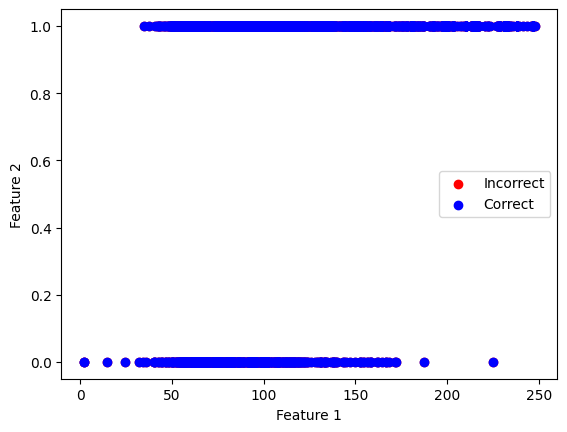

In [60]:
import matplotlib.pyplot as plt

# Предположим, что данные двумерные
plt.scatter(val_input[incorrect_indices][:, 0], val_input[incorrect_indices][:, 1], color='red', label='Incorrect')
plt.scatter(val_input[incorrect_indices][:, 0], val_input[incorrect_indices][:, 1], color='blue', label='Correct')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()
